In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)


from csr3d.core import Es_case_B, Fx_case_B, Fx_case_B_Chris, psi_s, psi_x0

#from csr2d.core2 import psi_s, psi_x0, Es_case_B, Fx_case_B, Fx_case_B_Chris
#from csr2d.kick2 import green_meshes_no_phi
#from csr2d.convolution import fftconvolve2

In [2]:
#from csr2d.kick2 import green_meshes_no_phi
from csr3d.convolution import fftconvolve3

#from csr2d.central_difference import central_difference_z

import time

import concurrent.futures as cf

from scipy import integrate

import tanh_sinh


import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Chris's parameters for benchmarking

In [3]:
gamma = 500
rho = 1.0 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

sigma_x  = 10e-6
sigma_y  = 10e-6
sigma_z  = 10e-6

In [4]:
psi_s(-2*sigma_x, 2*sigma_y, 2*sigma_z, gamma)

-40.74482046156819

In [13]:
Fx_case_B(-2*sigma_x, 2*sigma_y, 2*sigma_z, gamma)

8166.890361164815

In [14]:
Fx_case_B_Chris(-2*sigma_x, 2*sigma_y, 2*sigma_z, gamma)

8307.52501763286

## code

In [4]:
# Bypassing the beam, use smooth Gaussian distribution

#def lamb_2d(z,x):
#    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
#def lamb_2d_prime(z,x):
#    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

def lamb_3d(x,y,z):
    return 1/((2*np.pi)**(3/2)*sigma_x*sigma_y*sigma_z)* np.exp(-z**2/2/sigma_z**2 - x**2/2/sigma_x**2 - y**2/2/sigma_y**2)
def lamb_3d_prime(x,y,z):
    return 1/((2*np.pi)**(3/2)*sigma_x*sigma_y*sigma_z)* np.exp(-z**2/2/sigma_z**2 - x**2/2/sigma_x**2 - y**2/2/sigma_y**2) * (-z / sigma_z**2)

In [6]:
nx = 10
ny = 10
nz = 10

xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
yvec = np.linspace(-5*sigma_y, 5*sigma_y, ny)
zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)

X, Y, Z = np.meshgrid( xvec, yvec, zvec, indexing='ij')

lambda_grid_filtered = lamb_3d(X,Y,Z)
lambda_grid_filtered_prime = lamb_3d_prime(X,Y,Z)

dx = (10*sigma_x) / (nx - 1)
dy = (10*sigma_y) / (ny - 1)
dz = (10*sigma_z) / (nz - 1)


#psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes_no_phi(nz, nx, dz, dx, rho=rho, beta=beta)  

dxp = dx/rho
dyp = dy/rho
dzp = dz/2/rho

# Double-sized array for convolution with the density
xvec2 = np.arange(-nx+1,nx+1,1)*dxp # center = 0 is at [nx-1]
yvec2 = np.arange(-ny+1,ny+1,1)*dyp # center = 0 is at [nx-1]
zvec2 = np.arange(-nz+1,nz+1,1)*dzp # center = 0 is at [nz-1]

X2, Y2, Z2 = np.meshgrid(xvec2, yvec2, zvec2, indexing="ij")


psi_s_grid = psi_s(X2, Y2, Z2, gamma) # Numba routines!
psi_x_grid = psi_x0(X2, Y2, Z2, gamma, dx, dy, dz) # Will average around 0


Es_case_B_grid = Es_case_B(X2, Y2, Z2, gamma) 
Fx_case_B_grid = Fx_case_B(X2, Y2, Z2, gamma) 


conv_s = fftconvolve3(lambda_grid_filtered_prime, psi_s_grid)[0]
#conv_s2 = fftconvolve2(lambda_grid_filtered, Es_case_B_grid)[0]

conv_x = fftconvolve3(lambda_grid_filtered_prime, psi_x_grid)[0]
#conv_x2 = fftconvolve2(lambda_grid_filtered, Fx_case_B_grid)[0]


##Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)
##Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)



In [21]:
kkk = np.linspace(-1e-6,1e-6,101)

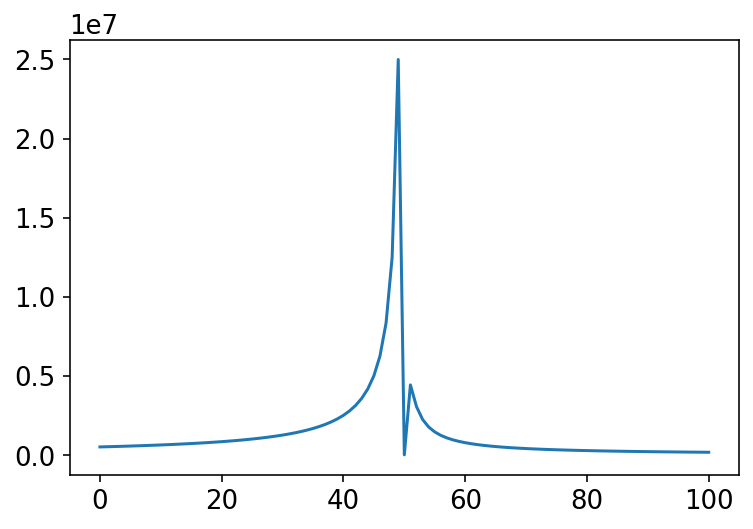

In [27]:
plt.plot(Fx_case_B(0,0,kkk,gamma))

In [ ]:
x_observe = 0
y_observe = 0
x_observe_index = np.argmin(np.abs(xvec2 - x_observe))
y_observe_index = np.argmin(np.abs(yvec2 - y_observe))

print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s[x_observe_index,y_observe_index,:]* (dx*dy*dz), label=r'$\int \psi_s ~ \lambda_p}$',linewidth=5)
##plt.plot(zvec, conv_s4[:,x_observe_index]* (dz * dx), label=r'$\int E_s(IGF) ~ \lambda}$')

plt.xlabel(r'x/$\rho$', fontsize=16)
plt.ylabel(r'$Ws (1/m^2)$', fontsize=16)
plt.title(fr'$Ws(x,y,z)$ along x={x_observe} mm, y={y_observe} mm',  fontsize=20, pad=20)
plt.legend()

x_observe_index : 50


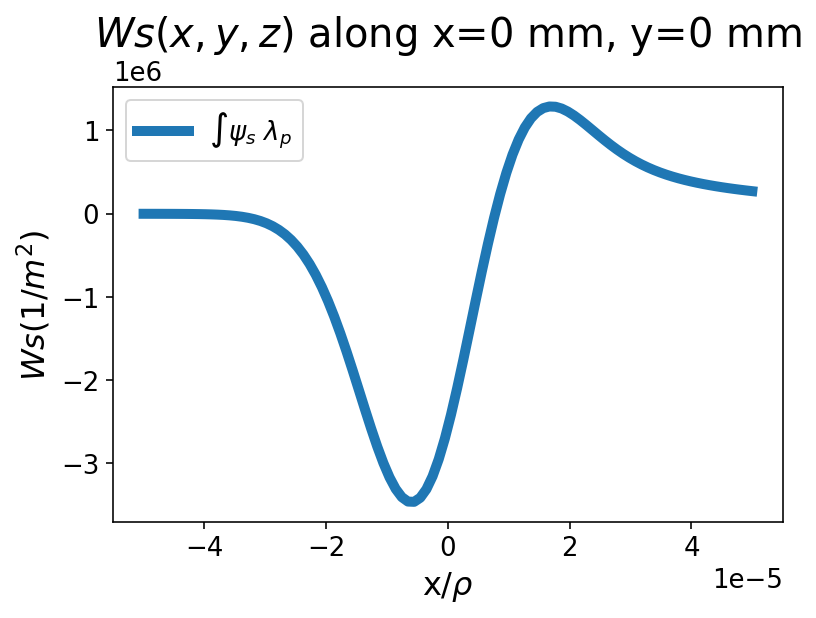

In [11]:
x_observe = 0
y_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
y_observe_index = np.argmin(np.abs(yvec - y_observe))

print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s[x_observe_index,y_observe_index,:]* (dx*dy*dz), label=r'$\int \psi_s ~ \lambda_p}$',linewidth=5)
##plt.plot(zvec, conv_s4[:,x_observe_index]* (dz * dx), label=r'$\int E_s(IGF) ~ \lambda}$')

plt.xlabel(r'x/$\rho$', fontsize=16)
plt.ylabel(r'$Ws (1/m^2)$', fontsize=16)
plt.title(fr'$Ws(x,y,z)$ along x={x_observe} mm, y={y_observe} mm',  fontsize=20, pad=20)
plt.legend()

In [12]:
np.where(np.isnan(Fx_case_B_grid))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [9]:
jaja = np.where(np.isnan(Fx_case_B_grid), 0, Fx_case_B_grid)

x_observe_index : 9


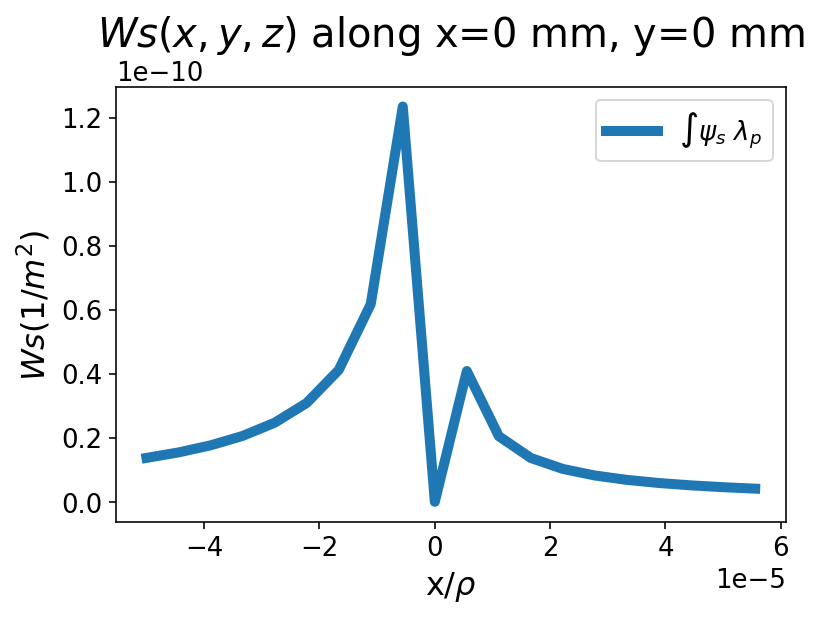

In [10]:
x_observe = 0
y_observe = 0
x_observe_index = np.argmin(np.abs(xvec2 - x_observe))
y_observe_index = np.argmin(np.abs(yvec2 - y_observe))

print('x_observe_index :', x_observe_index )
plt.plot(zvec2, jaja[x_observe_index,y_observe_index,:]* (dx*dy*dz), label=r'$\int \psi_s ~ \lambda_p}$',linewidth=5)


plt.xlabel(r'x/$\rho$', fontsize=16)
plt.ylabel(r'$Ws (1/m^2)$', fontsize=16)
plt.title(fr'$Ws(x,y,z)$ along x={x_observe} mm, y={y_observe} mm',  fontsize=20, pad=20)
plt.legend()

Text(0.5, 0.92, '$Fx$ benchmarking')

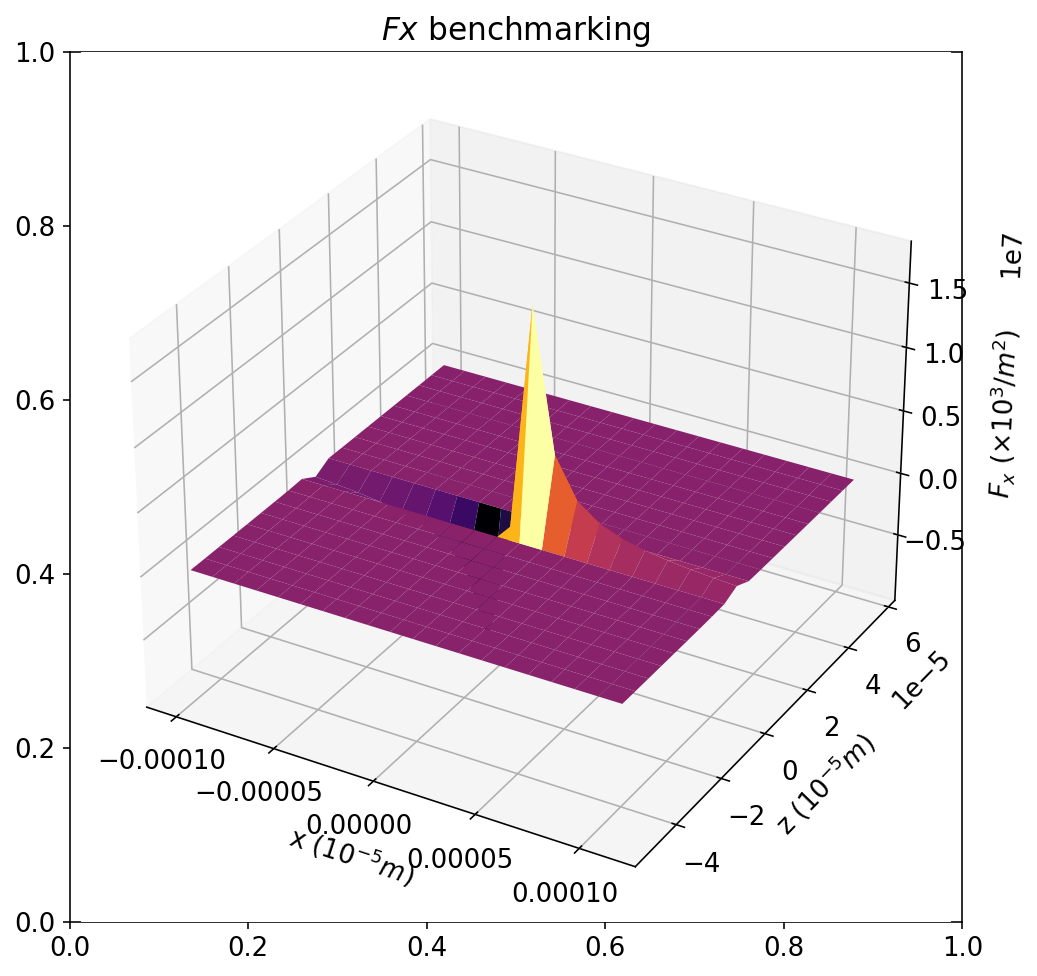

In [13]:
from mpl_toolkits import mplot3d

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(X2[:,y_observe_index,:], Z2[:,y_observe_index,:], jaja[:,y_observe_index,:], cmap='inferno', zorder=1)


ax.set_xlabel(r'x $(10^{-5}m)$')
ax.set_ylabel(r'z $(10^{-5}m)$')
ax.set_zlabel(r'$F_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$Fx$ benchmarking')

In [50]:
Z2.flatten().shape

(8000,)

In [14]:
ix_for_IGF = np.where(abs(Z2.flatten())<dzp*1.2)
Z2_flatten_short = Z2.flatten()[ix_for_IGF]
X2_flatten_short = X2.flatten()[ix_for_IGF]
Y2_flatten_short = Y2.flatten()[ix_for_IGF]

In [15]:
Z2_flatten_short.shape

(1200,)

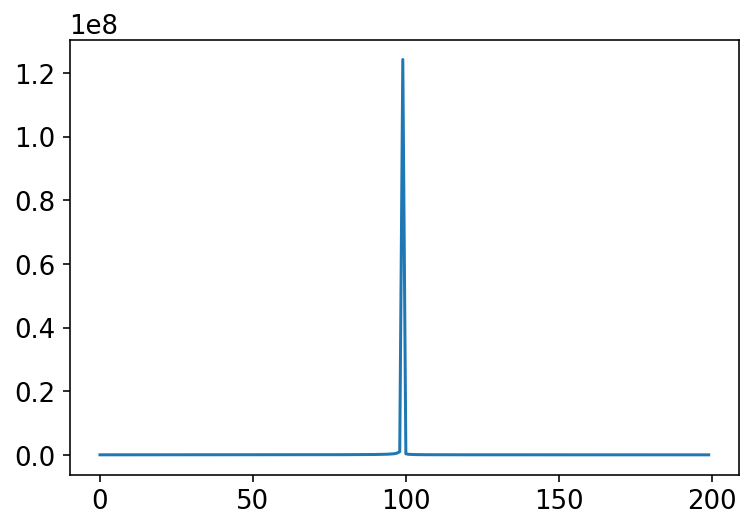

In [33]:
plt.plot(jaja[100,100,:])

In [16]:
# Want functions in terms of (x,y,z) only
psi_s_xyz = lambda x,y,z: psi_s(x,y,z,gamma)
psi_x_xyz = lambda x,y,z: psi_x0(x,y,z,gamma,dx,dy,dz)

Es_case_B_xyz = lambda x,y,z: Es_case_B(x,y,z,gamma)
Fx_case_B_xyz = lambda x,y,z: Fx_case_B(x,y,z,gamma)
Fx_case_B_Chris_xyz = lambda x,y,z: Fx_case_B_Chris(x,y,z,gamma)


def IGF_nquad(func, xval, yval, zval, dx, dy, dz):
    return integrate.nquad(func, [[xval-dx/2, xval+dx/2], [yval-dy/2, yval+dy/2], [zval-dz/2, zval+dz/2]])[0]

def IGF_nquad_psi_s(x,y,z):
    return IGF_nquad(psi_s_xyz, x,y,z, dx, dy, dz)

def IGF_nquad_Es_case_B(x,y,z):
    return IGF_nquad(Es_case_B_xyz, x,y,z, dx, dy, dz)

def IGF_nquad_psi_x(x,y,z):
    return IGF_nquad(psi_x_xyz, x,y,z, dx, dy, dz)

def IGF_nquad_Fx_case_B(x,y,z):
    return IGF_nquad(Fx_case_B_xyz, x,y,z, dx, dy, dz)

def IGF_nquad_Fx_case_B_Chris(x,y,z):
    return IGF_nquad(Fx_case_B_Chris_xyz, x,y,z, dx, dy, dz)

In [65]:
t1 = time.time()
integrate.nquad(Es_case_B_xyz, [[sigma_x-dx/2, sigma_x+dx/2], [sigma_y-dy/2, sigma_y+dy/2], [sigma_z-dz/2, sigma_z+dz/2]])
t2 = time.time()
print('it takes:', t2-t1,'sec')

it takes: 131.59141325950623 sec


In [ ]:
epsabs=1.49e-08

In [32]:
t1 = time.time()
psi_s_000 = IGF_nquad_psi_s(sigma_x,sigma_y,sigma_z)
t2 = time.time()
print('it takes:', t2-t1,'sec')

it takes: 126.38131332397461 sec


In [33]:
psi_s_000

-4.0817243503000343e-16

In [17]:
# func must have two arguments only (z,x,y)
# Might want to pass in dzp instead of dz....

def IGF_test(func, xval, yval, zval, dx, dy, dz):

    def func_z(z):
        return func(xval, yval, z)
    
    if abs(zval) < 1e-14:
        if (abs(xval) < 1e-14) and (abs(yval)< 1e-14):
            return 0
        else:
            term1 = tanh_sinh.integrate(func_z, -dz/2/rho/2, 0, 1e-6, max_steps=40)[0]
            term2 = tanh_sinh.integrate(func_z, 0, dz/2/rho/2,  1e-6, max_steps=40)[0]
            return term1 + term2        
    else:
        #return integrate.nquad(func, [[zval-dz/2, zval+dz/2], [xval-dx/2, xval+dx/2]], opts={'epsabs':1e-12})
        return tanh_sinh.integrate(func_z, zval-dz/2/rho/2, zval+dz/2/rho/2, 1e-12, max_steps=30)[0]
    
#def IGF_tanh_psi_s(zval, xval):
#    return IGF_test(psi_s_zx, zval, xval, dz, dx)

def IGF_tanh_Es_case_B(xval, yval, zval):
    return IGF_test(Es_case_B_xyz, xval, yval, zval, dx, dy, dz)

def IGF_tanh_Fx_case_B(xval, yval, zval):
    return IGF_test(Fx_case_B_xyz, xval, yval, zval, dx, dy, dz)

In [23]:
IGF_test(Fx_case_B_xyz, 0, 0, 0, dx, dy, dz)

0

In [39]:
IGF_tanh_Fx_case_B(xvec2[50],yvec2[50],zvec2[49])

0.5493061443340965

In [58]:
Z2.flatten().shape

(64000,)

In [28]:
.reshape(Z2.shape)

(102, 102, 102)

In [ ]:
Z2_flatten_short 

In [18]:
## Quick test
ix_start= 100
ix_end = 200

with cf.ThreadPoolExecutor(max_workers=16) as executor:
    t1 = time.time()
    temp = executor.map(IGF_tanh_Fx_case_B, X2.flatten()[ix_start:ix_end], Y2.flatten()[ix_start:ix_end], Z2.flatten()[ix_start:ix_end])
    Fx_case_B_grid_IGF_tanh = np.array(list(temp))   
    t2 = time.time()
print('IGF for Fx_case_B takes:', t2-t1, 'sec')

IGF for Fx_case_B takes: 0.1806790828704834 sec


In [ ]:
## Quick test
ix_start= 0
ix_end = 100


with cf.ThreadPoolExecutor(max_workers=16) as executor:
    t1 = time.time()
    temp = executor.map(IGF_tanh_Fx_case_B, X2_flatten_short[ix_start:ix_end], Y2_flatten_short[ix_start:ix_end], Z2_flatten_short[ix_start:ix_end])
    Fx_case_B_grid_IGF_tanh = np.array(list(temp))
    t2 = time.time()
    
print('IGF for Fx_case_B takes:', t2-t1, 'sec')

In [63]:
t1 = time.time()

with cf.ThreadPoolExecutor(max_workers=8) as executor:
    temp = executor.map(IGF_tanh_Fx_case_B, X2.flatten(), Y2.flatten(), Z2.flatten())
    Fx_case_B_grid_IGF_tanh = np.array(list(temp)).reshape(Z2.shape)
    
t2 = time.time()
print('IGF for Fx_case_B takes:', t2-t1, 'sec')

KeyboardInterrupt: 

In [30]:
Z.flatten().shape

(132651,)

In [ ]:
Fx_case_B_grid_IGF_tanh.shape

In [ ]:
conv_x4 = fftconvolve3(lambda_grid_filtered, Fx_case_B_grid_IGF_tanh/(dz/2/rho))[0]

In [14]:
# Try just the first points in the mesh
t1 = time.time()

temp = map( IGF_nquad_psi_s, zm2.flatten()[0:6], xm2.flatten()[0:6])
psi_s_grid_IGF = np.array(list(temp)).reshape(zm2.flatten()[0:6].shape)
    
t2 = time.time()
print('IGF for psi_s takes:', t2-t1, 'sec')

IGF for psi_s takes: 0.06542015075683594 sec


In [15]:
psi_s_grid_IGF

array([-1.00013134e-12, -9.90130057e-13, -9.80128753e-13, -9.70127429e-13,
       -9.60126088e-13, -9.50124728e-13])

In [16]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=16) as executor:
    temp = executor.map( IGF_nquad_Es_case_B, zm2.flatten(), xm2.flatten())
    Es_case_B_grid_IGF = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Es_case_B takes:', t2-t1, 'sec')

<ipython-input-10-43936f6b66a9>:5: RuntimeWarning: divide by zero encountered in Es_case_B
  Es_case_B_zx = lambda z, x: Es_case_B(z,x,beta)
<ipython-input-10-43936f6b66a9>:5: RuntimeWarning: invalid value encountered in Es_case_B
  Es_case_B_zx = lambda z, x: Es_case_B(z,x,beta)


IGF for Es_case_B takes: 39.93434143066406 sec


In [17]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=16) as executor:
    temp = executor.map( IGF_nquad_Fx_case_B, zm2.flatten(), xm2.flatten())
    Fx_case_B_grid_IGF = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Fx_case_B takes:', t2-t1, 'sec')

<ipython-input-10-43936f6b66a9>:6: RuntimeWarning: divide by zero encountered in Fx_case_B
  Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)
<ipython-input-10-43936f6b66a9>:6: RuntimeWarning: invalid value encountered in Fx_case_B
  Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)
<ipython-input-10-43936f6b66a9>:6: RuntimeWarning: divide by zero encountered in Fx_case_B
  Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)
<ipython-input-10-43936f6b66a9>:6: RuntimeWarning: invalid value encountered in Fx_case_B
  Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)


IGF for Fx_case_B takes: 47.668917655944824 sec


In [18]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=16) as executor:
    temp = executor.map( IGF_nquad_Fx_case_B_Chris, zm2.flatten(), xm2.flatten())
    Fx_case_B_grid_IGF_Chris = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Fx_case_B takes:', t2-t1, 'sec')

<ipython-input-10-43936f6b66a9>:7: RuntimeWarning: divide by zero encountered in Fx_case_B_Chris
  Fx_case_B_Chris_zx = lambda z, x: Fx_case_B_Chris(z,x,beta)
<ipython-input-10-43936f6b66a9>:7: RuntimeWarning: invalid value encountered in Fx_case_B_Chris
  Fx_case_B_Chris_zx = lambda z, x: Fx_case_B_Chris(z,x,beta)
<ipython-input-10-43936f6b66a9>:7: RuntimeWarning: divide by zero encountered in Fx_case_B_Chris
  Fx_case_B_Chris_zx = lambda z, x: Fx_case_B_Chris(z,x,beta)
<ipython-input-10-43936f6b66a9>:7: RuntimeWarning: invalid value encountered in Fx_case_B_Chris
  Fx_case_B_Chris_zx = lambda z, x: Fx_case_B_Chris(z,x,beta)


IGF for Fx_case_B takes: 64.84319305419922 sec


In [19]:
np.where(np.isnan(Fx_case_B_grid_IGF_Chris))

(array([ 99, 101]), array([100, 100]))

In [20]:
def replace_nan(grid):
    return np.where(np.isnan(grid), 0, grid)

In [23]:
Fx_case_B_grid_IGF_Chris_no_nan = replace_nan(Fx_case_B_grid_IGF_Chris)
Fx_case_B_grid_IGF_no_nan = replace_nan(Fx_case_B_grid_IGF)

In [18]:
jaja = np.where(np.isnan(Fx_case_B_grid_IGF), 0, Fx_case_B_grid_IGF)

Text(0.5, 0.92, '$W_x$ benchmarking')

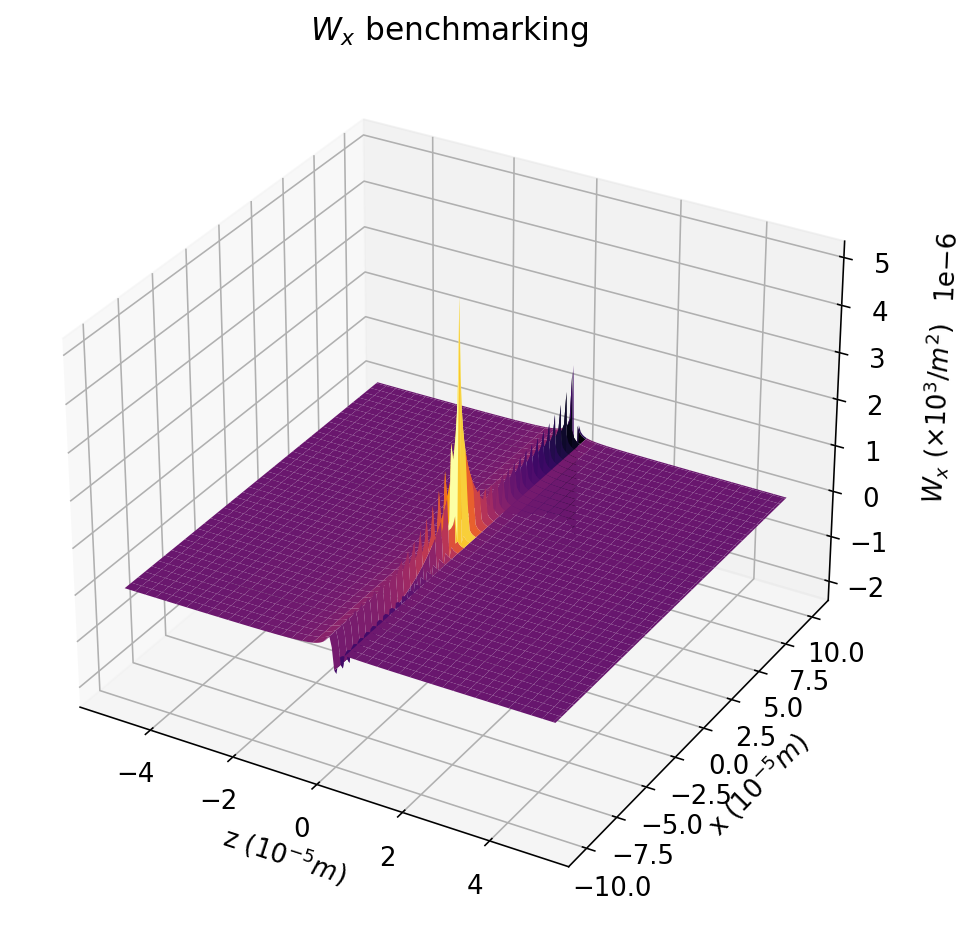

In [19]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, jaja, cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

Text(0.5, 0.92, '$W_x$ benchmarking')

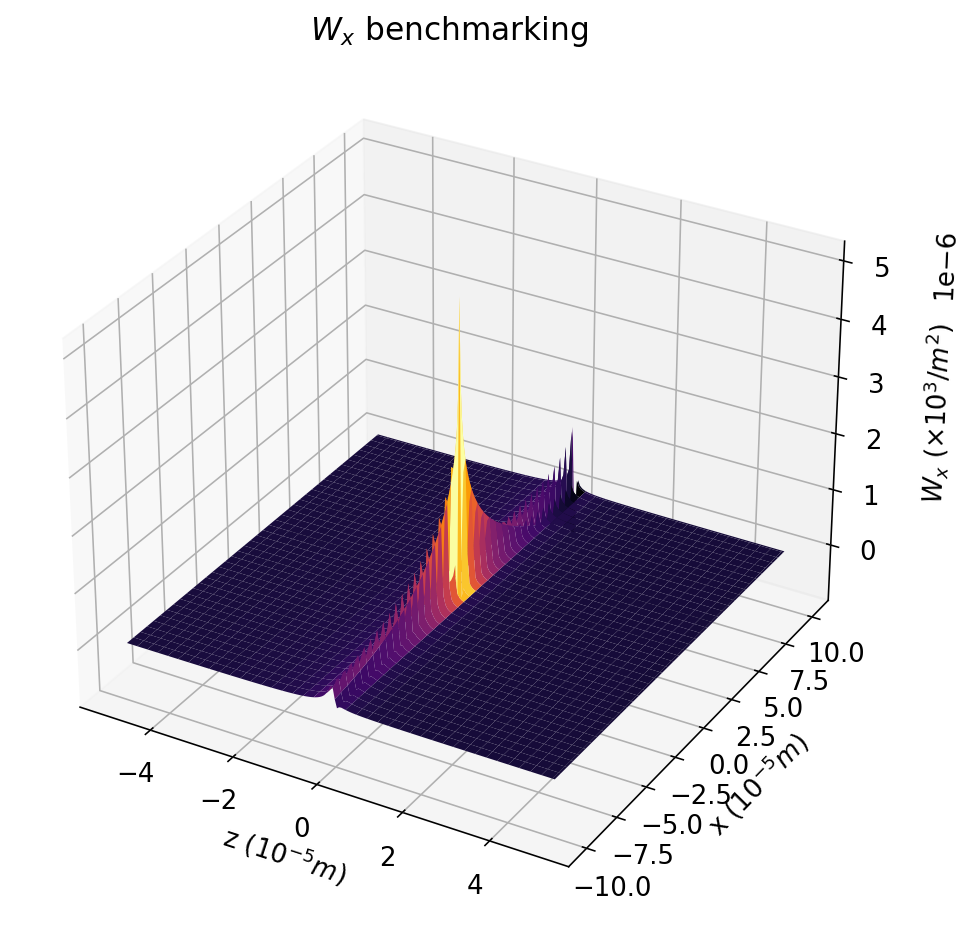

In [22]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, Fx_case_B_grid_IGF_Chris_no_nan , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

In [91]:
#lala = central_difference_z(psi_s_grid, 2*nz, 2*nx, dz, order=1)
#conv_s3 = fftconvolve2(lambda_grid_filtered, lala)[0]

In [24]:
#conv_s3 = fftconvolve2(lambda_grid_filtered, Es_case_B_grid_IGF/dz/dx)[0]
conv_x3 = fftconvolve2(lambda_grid_filtered, Fx_case_B_grid_IGF_no_nan/dz/dx)[0]
conv_x3_Chris = fftconvolve2(lambda_grid_filtered, Fx_case_B_grid_IGF_Chris_no_nan/dz/dx)[0]

x_observe_index : 50


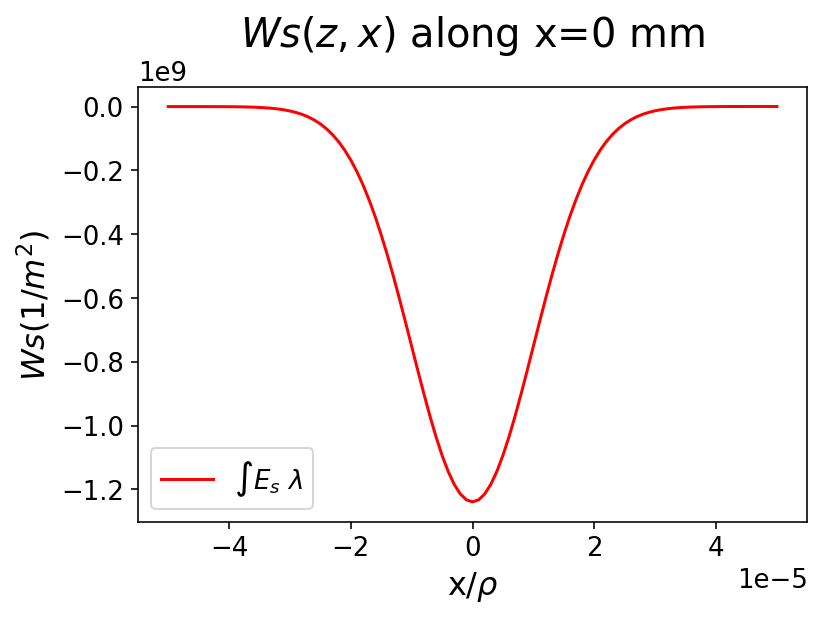

In [110]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s2[:,x_observe_index]* (dz * dx), label=r'$\int E_s ~ \lambda}$', c='red')

plt.xlabel(r'x/$\rho$', fontsize=16)
plt.ylabel(r'$Ws (1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z,x)$ along x={x_observe} mm',  fontsize=20, pad=20)
plt.legend()

In [48]:
Fx_case_B(0, 1e-30,beta)

9.999959999999998e+29

In [33]:
Z0 = np.array([-5.00000000e-05, -4.92187500e-05, -4.84375000e-05, -4.76562500e-05,
       -4.68750000e-05, -4.60937500e-05, -4.53125000e-05, -4.45312500e-05,
       -4.37500000e-05, -4.29687500e-05, -4.21875000e-05, -4.14062500e-05,
       -4.06250000e-05, -3.98437500e-05, -3.90625000e-05, -3.82812500e-05,
       -3.75000000e-05, -3.67187500e-05, -3.59375000e-05, -3.51562500e-05,
       -3.43750000e-05, -3.35937500e-05, -3.28125000e-05, -3.20312500e-05,
       -3.12500000e-05, -3.04687500e-05, -2.96875000e-05, -2.89062500e-05,
       -2.81250000e-05, -2.73437500e-05, -2.65625000e-05, -2.57812500e-05,
       -2.50000000e-05, -2.42187500e-05, -2.34375000e-05, -2.26562500e-05,
       -2.18750000e-05, -2.10937500e-05, -2.03125000e-05, -1.95312500e-05,
       -1.87500000e-05, -1.79687500e-05, -1.71875000e-05, -1.64062500e-05,
       -1.56250000e-05, -1.48437500e-05, -1.40625000e-05, -1.32812500e-05,
       -1.25000000e-05, -1.17187500e-05, -1.09375000e-05, -1.01562500e-05,
       -9.37500000e-06, -8.59375000e-06, -7.81250000e-06, -7.03125000e-06,
       -6.25000000e-06, -5.46875000e-06, -4.68750000e-06, -3.90625000e-06,
       -3.12500000e-06, -2.34375000e-06, -1.56250000e-06, -7.81250000e-07,
        2.92755762e-20,  7.81250000e-07,  1.56250000e-06,  2.34375000e-06,
        3.12500000e-06,  3.90625000e-06,  4.68750000e-06,  5.46875000e-06,
        6.25000000e-06,  7.03125000e-06,  7.81250000e-06,  8.59375000e-06,
        9.37500000e-06,  1.01562500e-05,  1.09375000e-05,  1.17187500e-05,
        1.25000000e-05,  1.32812500e-05,  1.40625000e-05,  1.48437500e-05,
        1.56250000e-05,  1.64062500e-05,  1.71875000e-05,  1.79687500e-05,
        1.87500000e-05,  1.95312500e-05,  2.03125000e-05,  2.10937500e-05,
        2.18750000e-05,  2.26562500e-05,  2.34375000e-05,  2.42187500e-05,
        2.50000000e-05,  2.57812500e-05,  2.65625000e-05,  2.73437500e-05,
        2.81250000e-05,  2.89062500e-05,  2.96875000e-05,  3.04687500e-05,
        3.12500000e-05,  3.20312500e-05,  3.28125000e-05,  3.35937500e-05,
        3.43750000e-05,  3.51562500e-05,  3.59375000e-05,  3.67187500e-05,
        3.75000000e-05,  3.82812500e-05,  3.90625000e-05,  3.98437500e-05,
        4.06250000e-05,  4.14062500e-05,  4.21875000e-05,  4.29687500e-05,
        4.37500000e-05,  4.45312500e-05,  4.53125000e-05,  4.60937500e-05,
        4.68750000e-05,  4.76562500e-05,  4.84375000e-05,  4.92187500e-05,
        5.00000000e-05])

Wx0 = np.array([ 20924.1025531 ,  21292.69283807,  21675.07566734,  22072.64554097,
        22487.21221166,  22919.01062748,  23371.06883308,  23843.81093142,
        24338.99268096,  24856.05697075,  25404.77159184,  25976.98376743,
        26584.9350702 ,  27242.68762092,  27917.95683103,  28651.19870504,
        29446.0837835 ,  30258.85625712,  31175.32941465,  32167.02053868,
        33244.64913318,  34409.76693433,  35712.81653206,  37153.9554634 ,
        38708.38439955,  40443.1536767 ,  42336.32048817,  44500.61953054,
        46799.5942963 ,  49499.64654115,  52458.01837621,  55983.12795791,
        59310.7858697 ,  63329.82412636,  67871.78231555,  72914.4241459 ,
        78393.43259127,  84407.93747769,  90657.34087464,  97940.4537008 ,
       106517.9413773 , 113823.69399398, 122874.33235029, 131884.92786995,
       141707.7877252 , 151930.88900143, 163219.02483719, 174193.16405926,
       185572.50046693, 196721.05530785, 208640.23881089, 220144.12600383,
       230951.66772263, 242050.48447076, 252355.50489707, 261128.4628703 ,
       269568.94749835, 277846.65706682, 284353.18921842, 289432.2936765 ,
       292395.72803898, 295449.13714478, 296553.74854004, 297310.70138594,
       295349.77985956, 291846.39260125, 286245.8054862 , 281330.25150242,
       273053.28627802, 264380.67016792, 255103.49640236, 244189.91701775,
       232821.27413835, 220281.42887161, 209356.67454658, 195841.30088595,
       184065.02847913, 171084.14752474, 158796.53215527, 146517.29662253,
       135011.14604831, 123138.59119762, 112324.58210574, 102398.36169647,
        92381.5679822 ,  83703.27470694,  75263.16397172,  67359.02086651,
        60514.57860239,  54339.69685499,  48884.84235149,  43806.25303235,
        39281.74796551,  34911.29235508,  31676.93370473,  28604.21140844,
        25851.65485099,  23538.82074127,  21693.65748305,  19653.11134228,
        18204.20423414,  16882.84141304,  15791.63462842,  14725.51409413,
        13945.54481385,  13160.16335164,  12512.77875792,  11899.33412465,
        11414.5239908 ,  10978.22703782,  10572.66063214,  10241.66658078,
         9923.31131116,   9628.56745008,   9369.73696388,   9117.96295579,
         8892.40247908,   8687.17468172,   8485.36276988,   8302.15002451,
         8127.41943805,   7957.17286717,   7793.65613881,   7646.54110121,
         7501.06438303,   7362.87432124,   7229.12819513,   7101.32309252,
         6978.40537546])

x_observe_index : 50


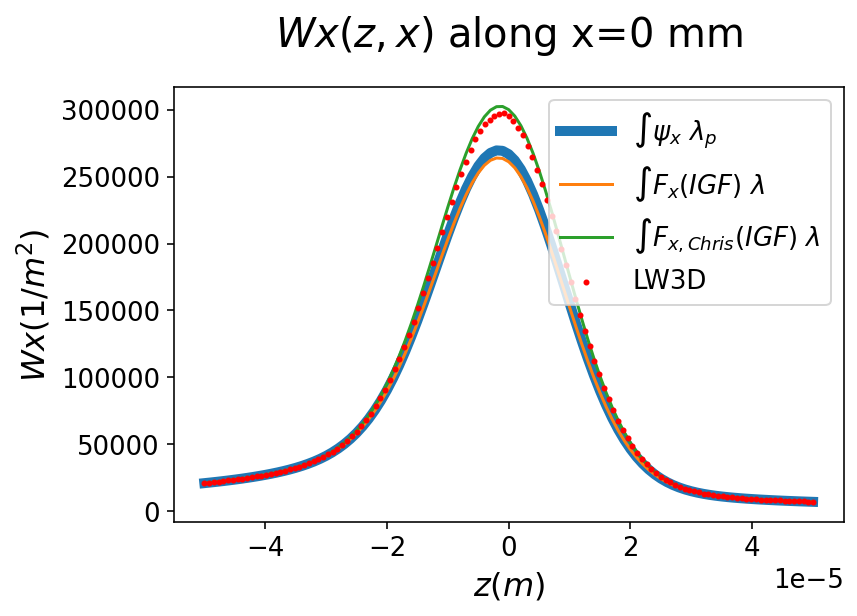

In [40]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_x[:,x_observe_index]* (dz * dx), label=r'$\int \psi_x ~ \lambda_p}$',linewidth=5)
plt.plot(zvec, conv_x3[:,x_observe_index]* (dz * dx), label=r'$\int F_x(IGF) ~ \lambda}$')
plt.plot(zvec, conv_x3_Chris[:,x_observe_index]* (dz * dx), label=r'$\int F_{x, Chris} (IGF) ~ \lambda}$')

plt.scatter(Z0,Wx0,c='red', zorder = 3, s=4, label='LW3D')

plt.xlabel(r'$z(m)$', fontsize=16)
plt.ylabel(r'$Wx (1/m^2)$', fontsize=16)
plt.title(fr'$Wx(z,x)$ along x={x_observe} mm',  fontsize=20, pad=20)
plt.legend()

In [32]:
conv_x3_Chris[50,50]* (dz * dx)

300107.4784288224

In [ ]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s[:,x_observe_index]* (dz * dx), label=r'$\int \psi_s ~ \lambda_p}$',linewidth=5)
plt.plot(zvec, conv_s4[:,x_observe_index]* (dz * dx), label=r'$\int E_s(IGF) ~ \lambda}$')

plt.xlabel(r'x/$\rho$', fontsize=16)
plt.ylabel(r'$Ws (1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z,x)$ along x={x_observe} mm',  fontsize=20, pad=20)
plt.legend()

Text(0.5, 0.92, '$W_x$ benchmarking')

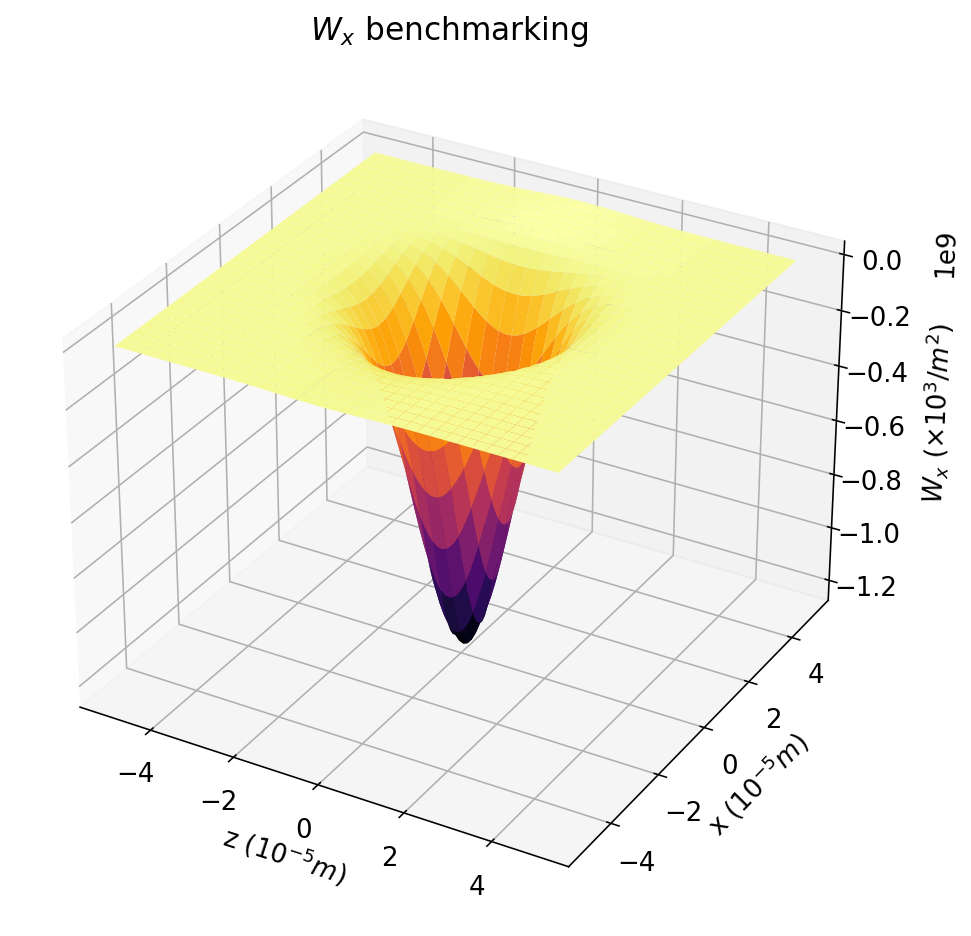

In [93]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, conv_s2*dz*dx , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

In [97]:
lala = central_difference_z(psi_s_grid, 2*nz, 2*nx, dz, order=1)

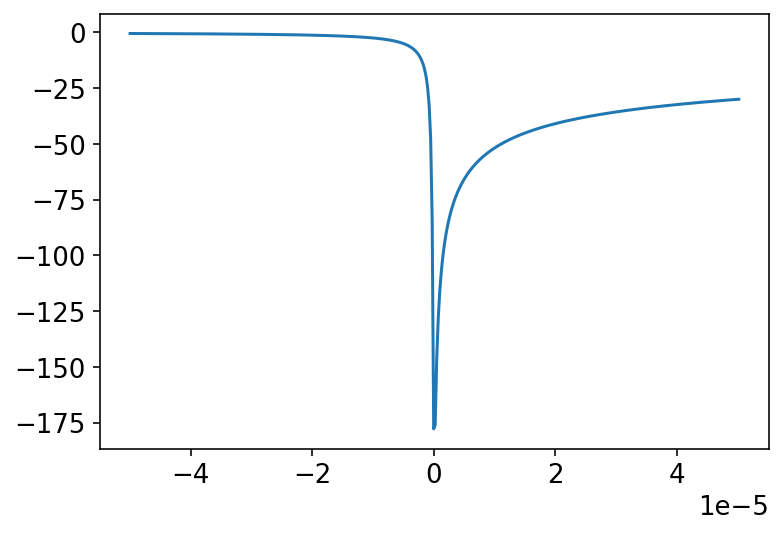

In [98]:
plt.plot(zvec2, psi_s_grid[:,x_observe_index])

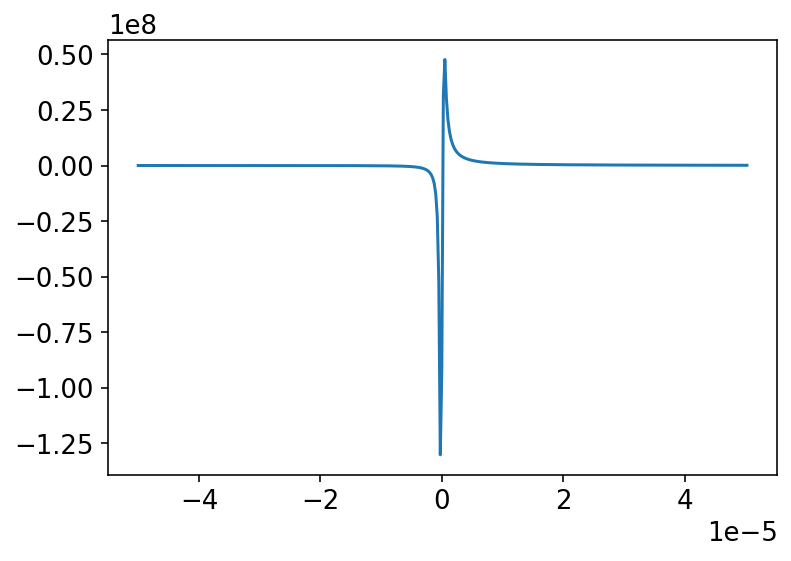

In [99]:
plt.plot(zvec2, lala[:,x_observe_index])

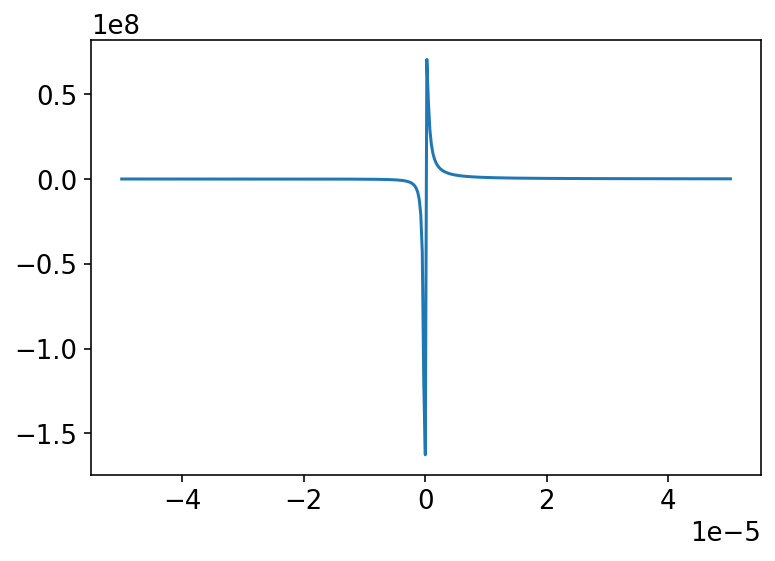

In [100]:
plt.plot(zvec2, Es_case_B_grid[:,x_observe_index])

In [102]:
conv_s3 = fftconvolve2(lambda_grid_filtered, lala)[0]

x_observe_index : 100


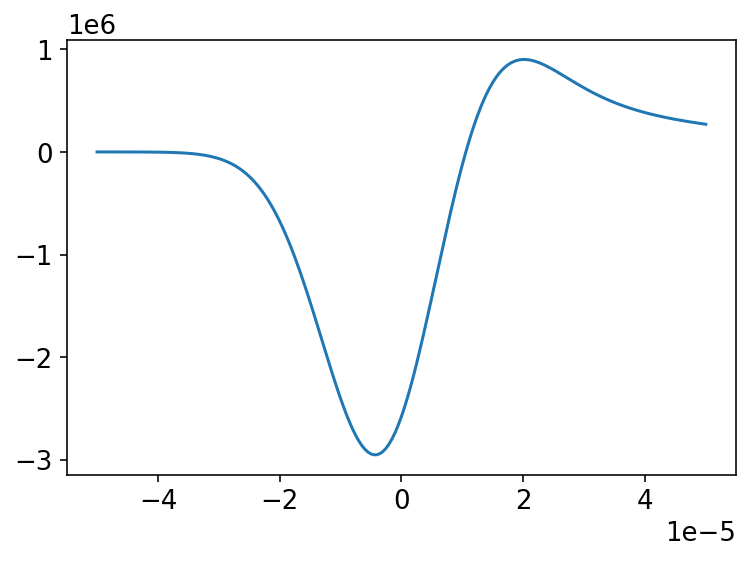

In [103]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s3[:,x_observe_index]* (dz * dx))

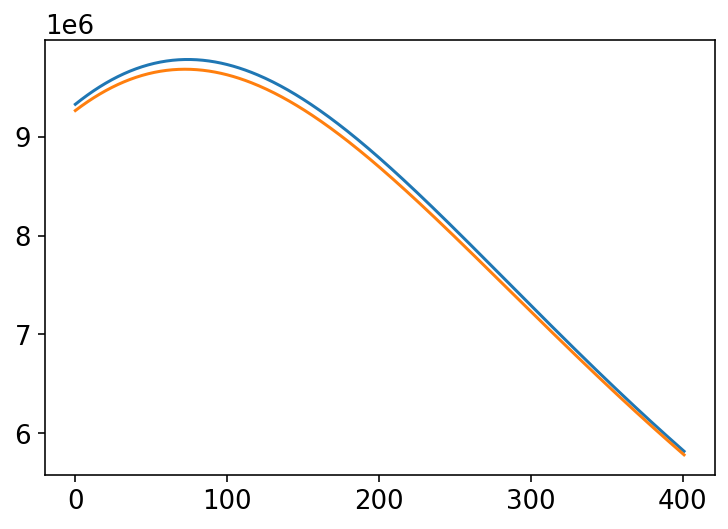

In [127]:
plt.plot(lala[207,:])
plt.plot(Es_case_B_grid[207,:])

In [146]:
zvec2[201]

2.5e-07

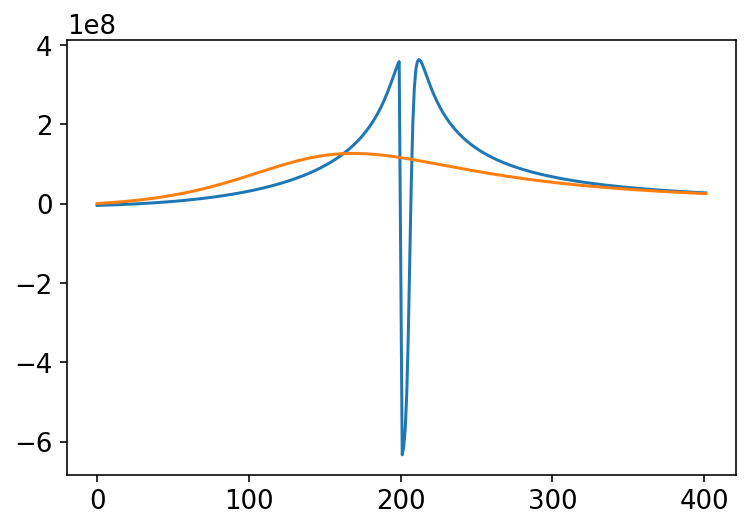

In [147]:
plt.plot(lala[201,:])
plt.plot(Es_case_B_grid[201,:])
#plt.yscale('log')

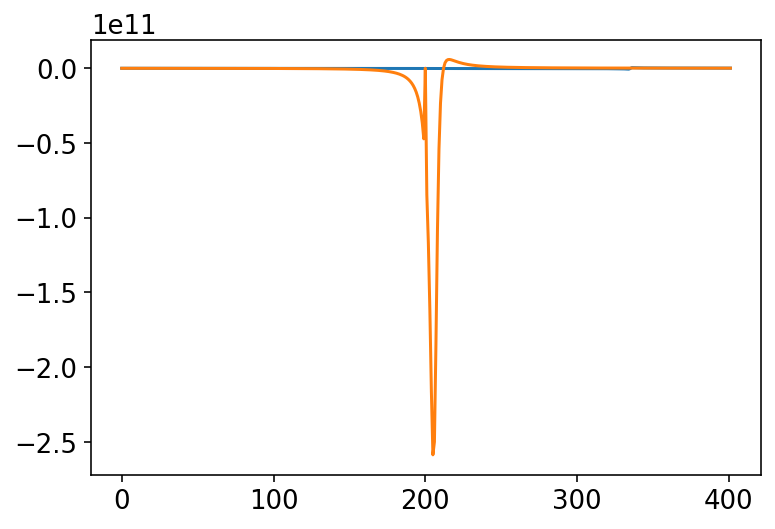

In [133]:
plt.plot(lala[200,:])
plt.plot(Es_case_B_grid[200,:])

In [142]:
from csr2d.core2 import alpha_exact_case_B_brentq
from csr2d.core2 import alpha

In [143]:
alpha(0,0,beta)

0.0

Text(0.5, 0.92, 'Es(z,x) Case B')

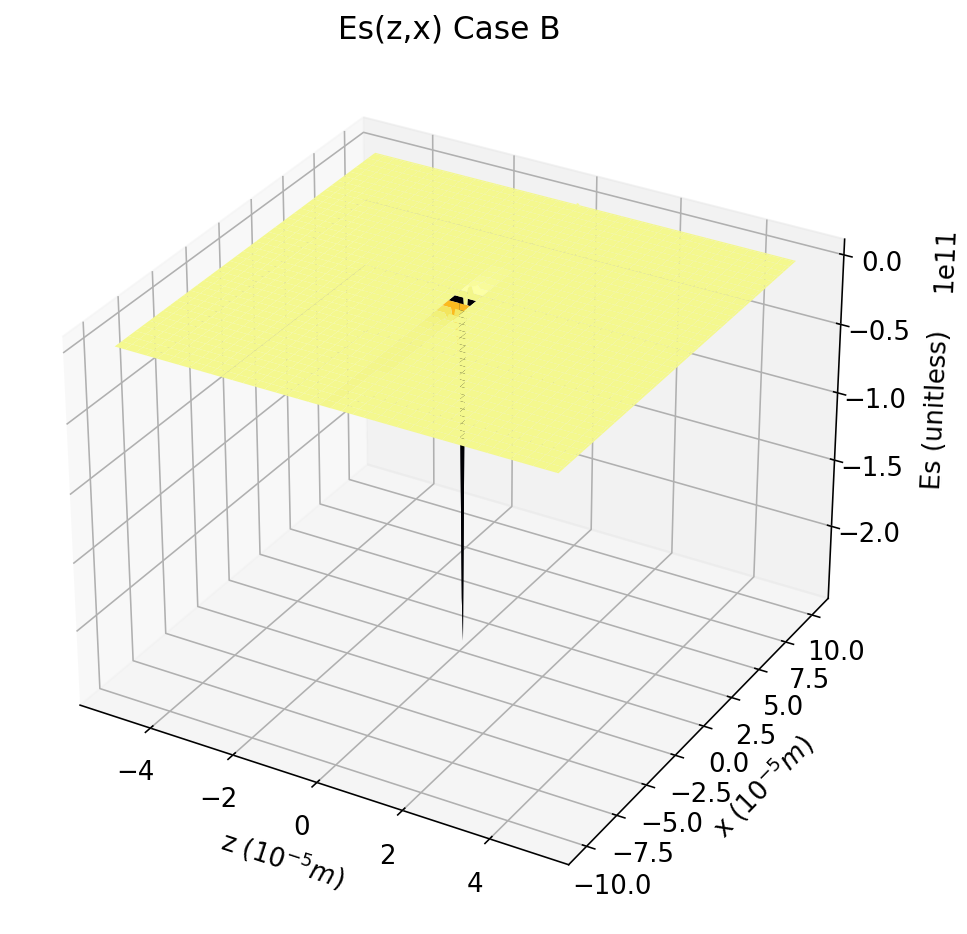

In [101]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, Es_case_B_grid , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$', labelpad = 6)
ax.set_ylabel(r'x $(10^{-5}m)$', labelpad = 6)
ax.set_zlabel(r'Es (unitless)')
ax.zaxis.labelpad = 10
ax.set_title(r'Es(z,x) Case B')

Text(0.5, 0.92, 'Es(z,x) quad_IGF Case B')

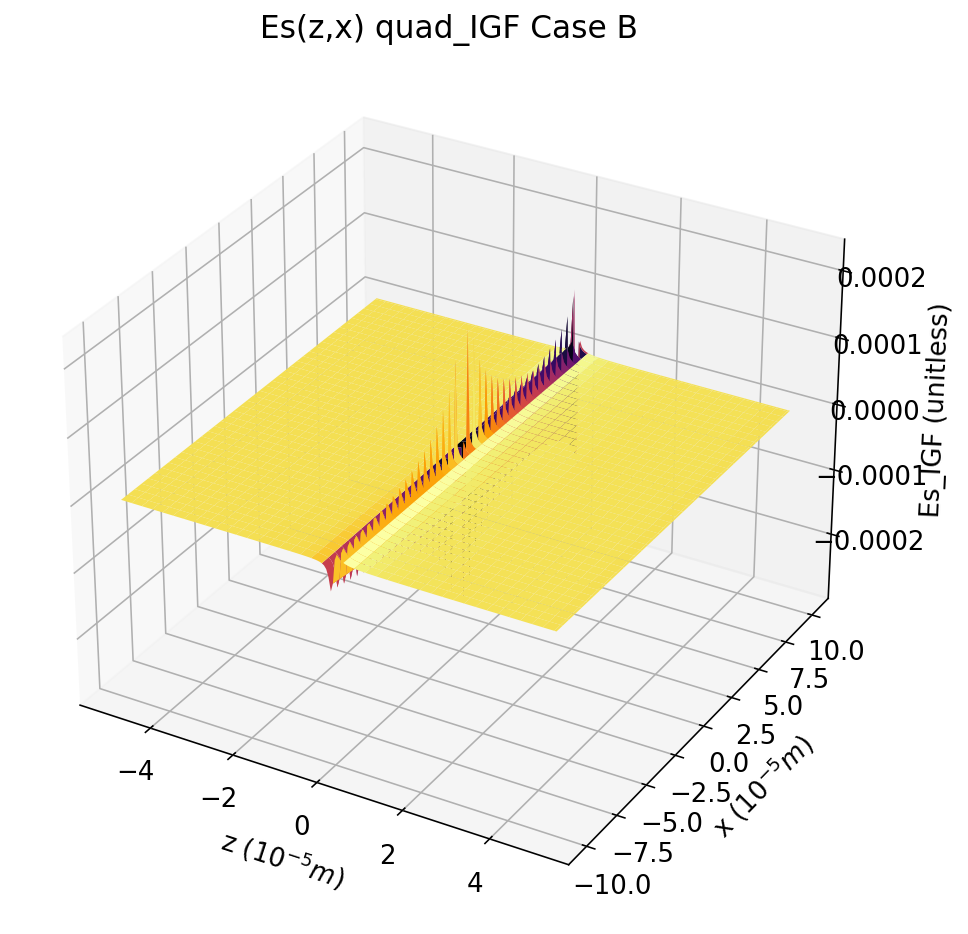

In [105]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, Es_case_B_grid_IGF , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$', labelpad = 6)
ax.set_ylabel(r'x $(10^{-5}m)$', labelpad = 6)
ax.set_zlabel(r'Es_IGF (unitless)', labelpad = 10)
ax.zaxis.labelpad = 10
ax.set_title(r'Es(z,x) quad_IGF Case B')

Text(0.5, 0.92, '$W_x$ benchmarking')

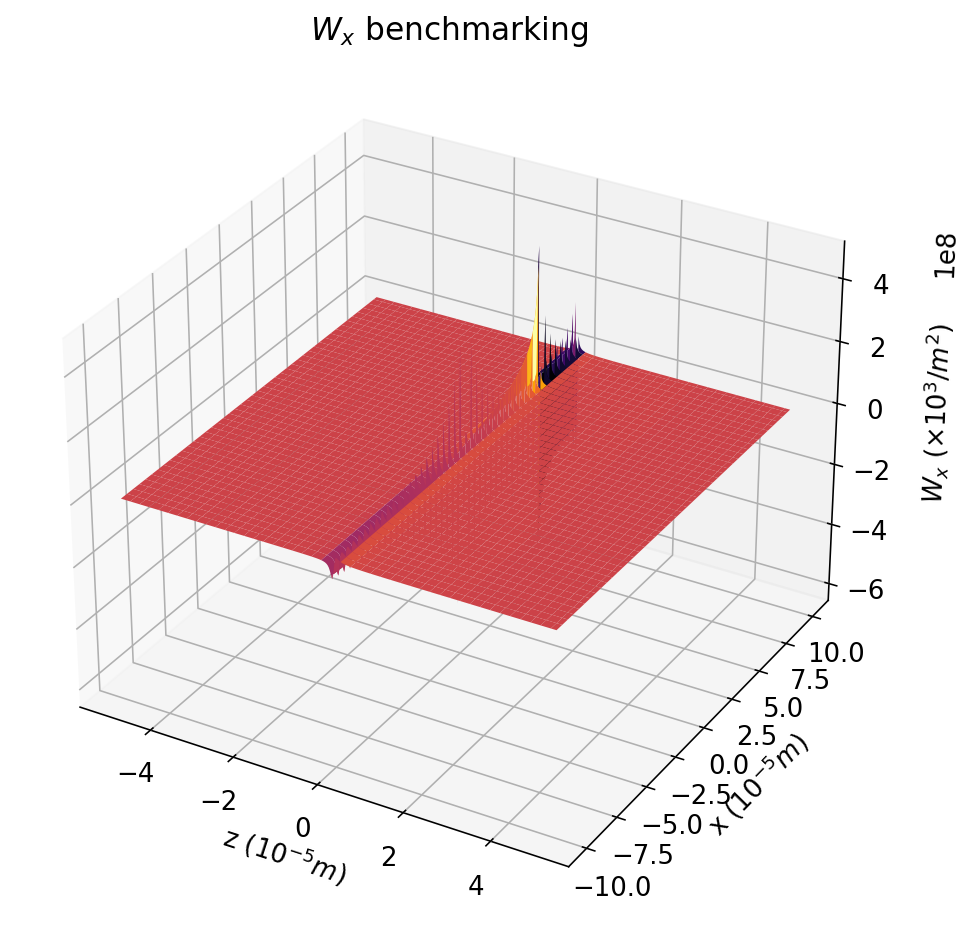

In [108]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, lala , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

Text(0.5, 0.92, '$W_x$ benchmarking')

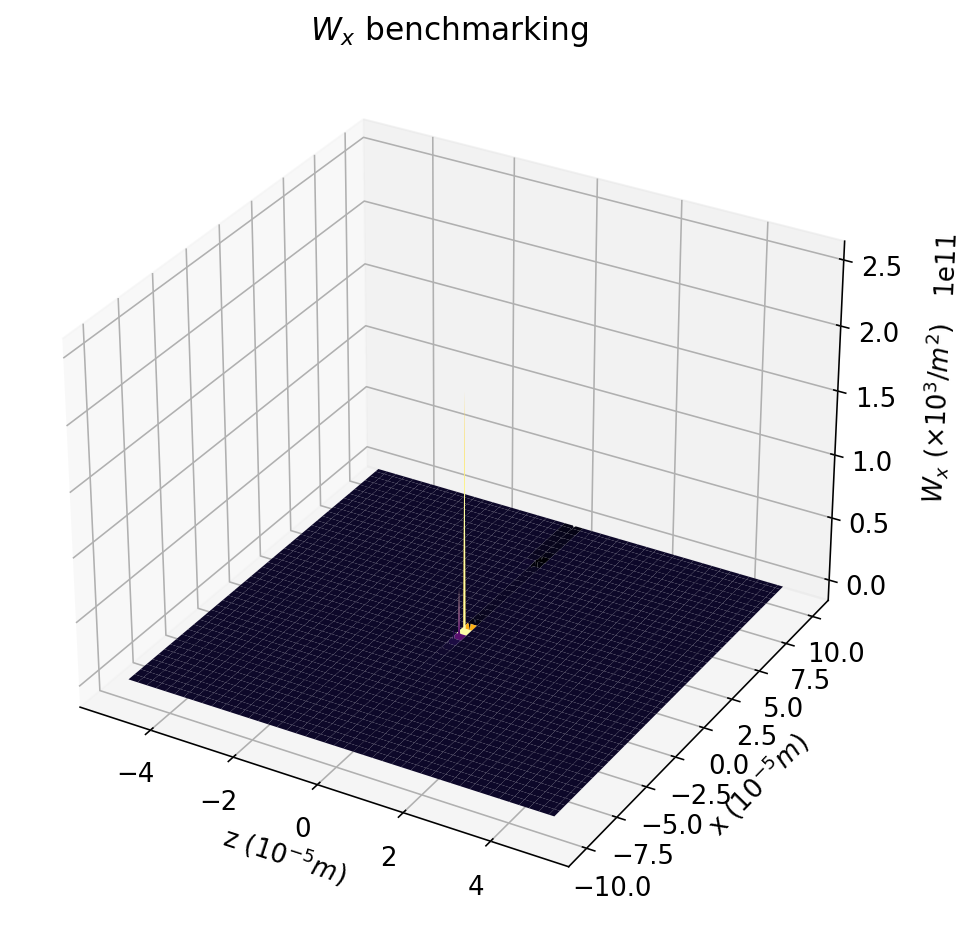

In [109]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, lala - Es_case_B_grid, cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

Text(0.5, 1.0, 'Wx(z) along x=0 mm')

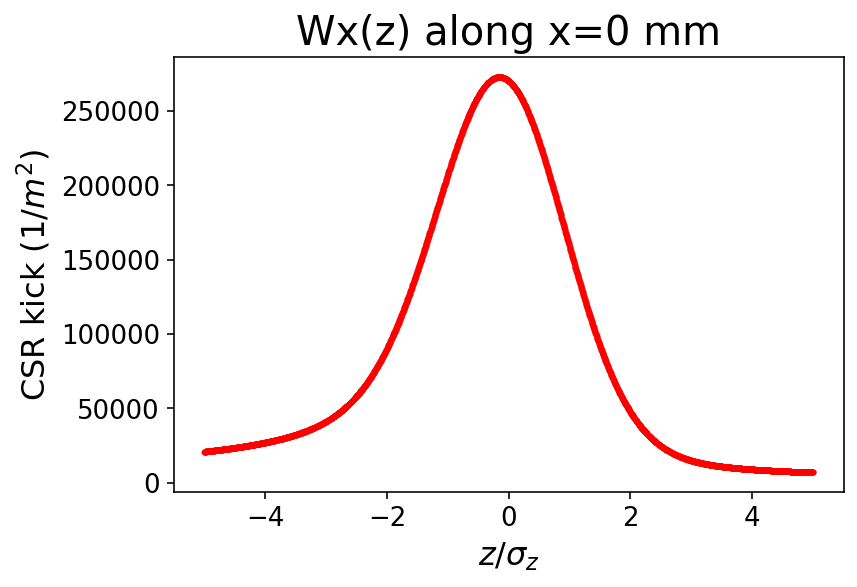

In [12]:
plt.scatter(zvec/sigma_z, Wx_grid[:,x_observe_index], color='red', label='$\phi$=', zorder=10, s=4)

plt.xlabel(r'$z/\sigma_z$', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)

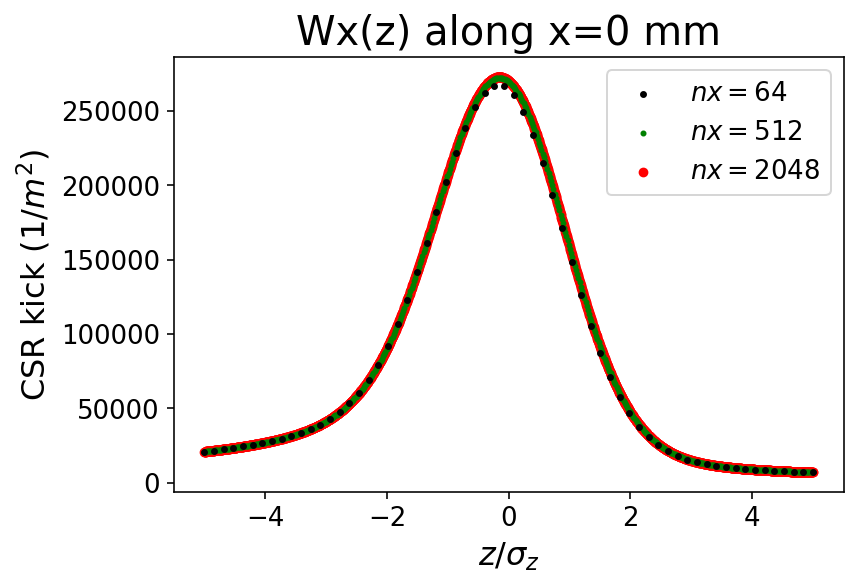

In [67]:
#plt.scatter(zvec_64/sigma_z, Wx_x0_64, color='black', label='$nx=64$', zorder=20, s=6)
#plt.scatter(zvec_512/sigma_z, Wx_x0_512, color='green', label='$nx=512$', zorder=15, s=4)
#plt.scatter(zvec_2048/sigma_z, Wx_x0_2048, color='red', label='$nx=2048$', zorder=10, s=15)


#plt.xlabel(r'$z/\sigma_z$', fontsize=16)
#plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
#plt.title('Wx(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
#plt.legend()

In [69]:
# Save the beam if needed
#haha = np.array(list(zip(zvec_2048/sigma_z,Wx_x0_2048)))
#np.savetxt("Wx_no_phi_Chris_parameter_nx2048.dat",haha)

Text(0.5, 0.92, '$W_x$ benchmarking')

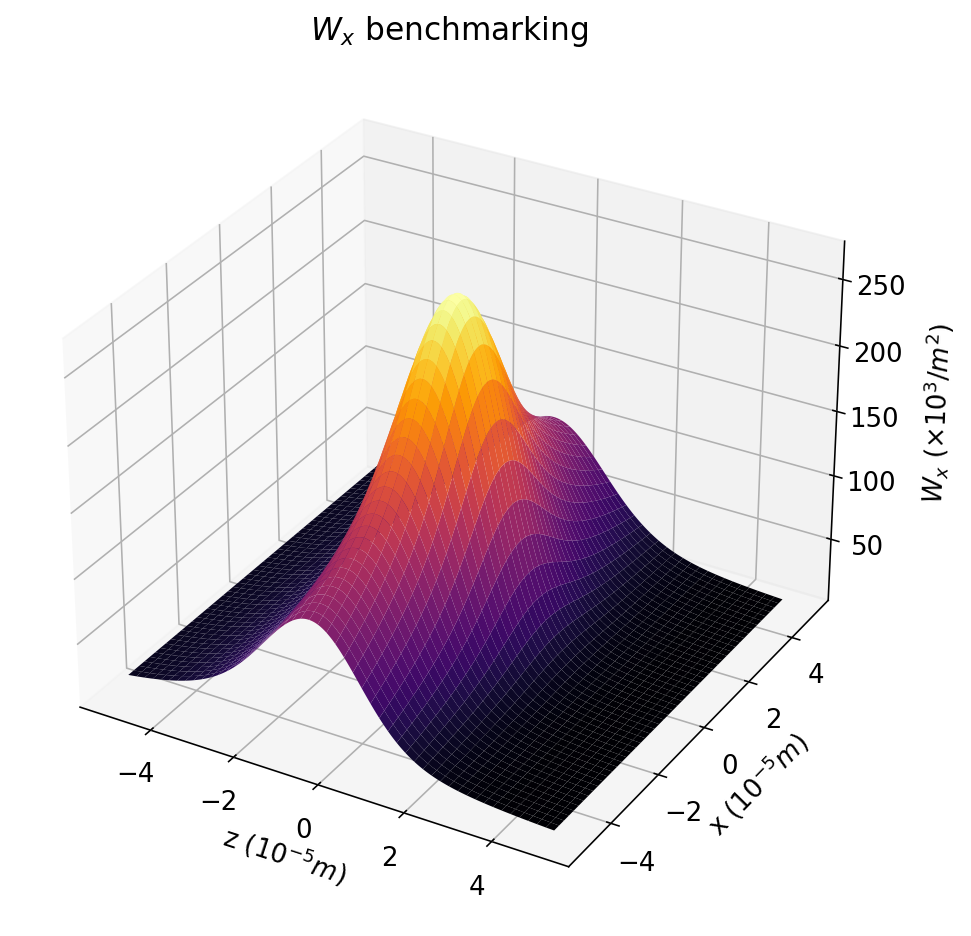

In [13]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Wx_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
#zline = np.linspace(min(zvec), max(zvec), 1000)
#xline = np.zeros(len(zline))
#fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
#ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

#ax.azim = 90

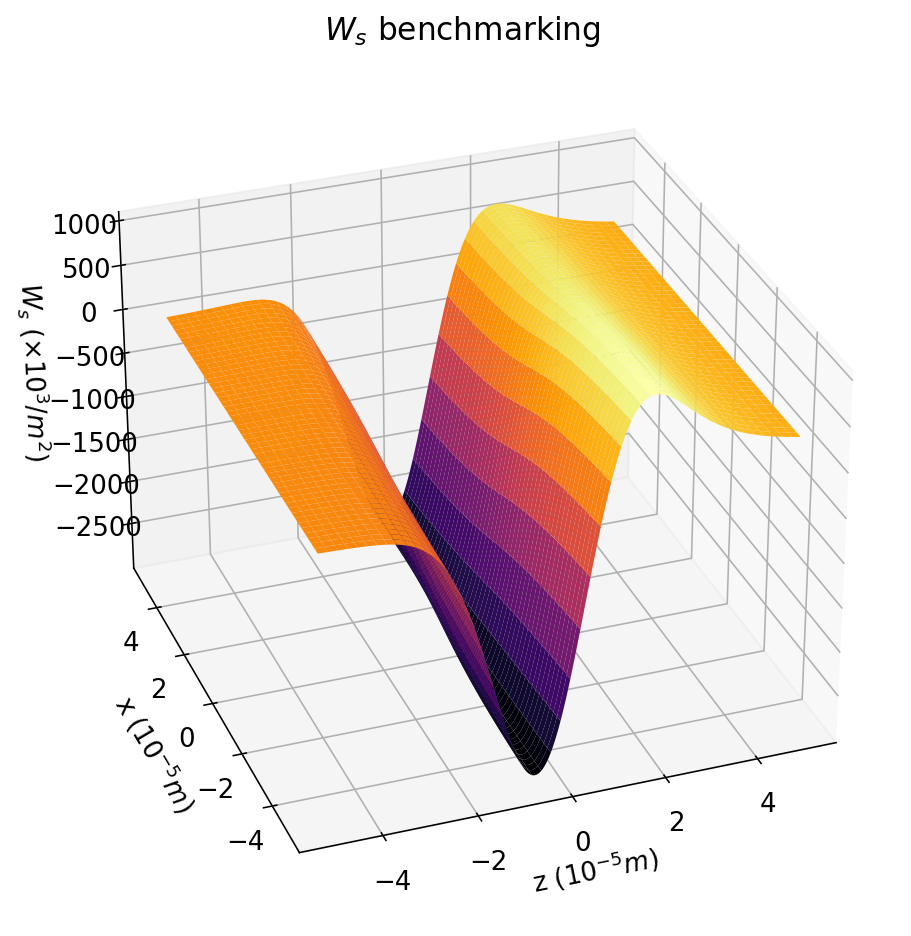

In [14]:
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Ws_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
#zline = np.linspace(min(zvec), max(zvec), 1000)
#xline = np.zeros(len(zline))
#fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
#ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_s$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_s$ benchmarking')

ax.azim = 250

# Checking the root finder

In [1]:
from csr2d.core2 import alpha_exact, alpha_exact_case_B_brentq

In [33]:
gamma = 500
beta = (1-1/gamma**2)**(1/2)

nz = 250
nx = 250

sigma_x  = 10e-6
sigma_z  = 10e-6

zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')


In [34]:
# Can be slow ( not jitted )
aa = alpha_exact(zm, xm, beta)

In [35]:
aa_brentq = alpha_exact_case_B_brentq(zm, xm, beta)

In [71]:
diff = np.abs(( aa_brentq - aa)/aa) * 100

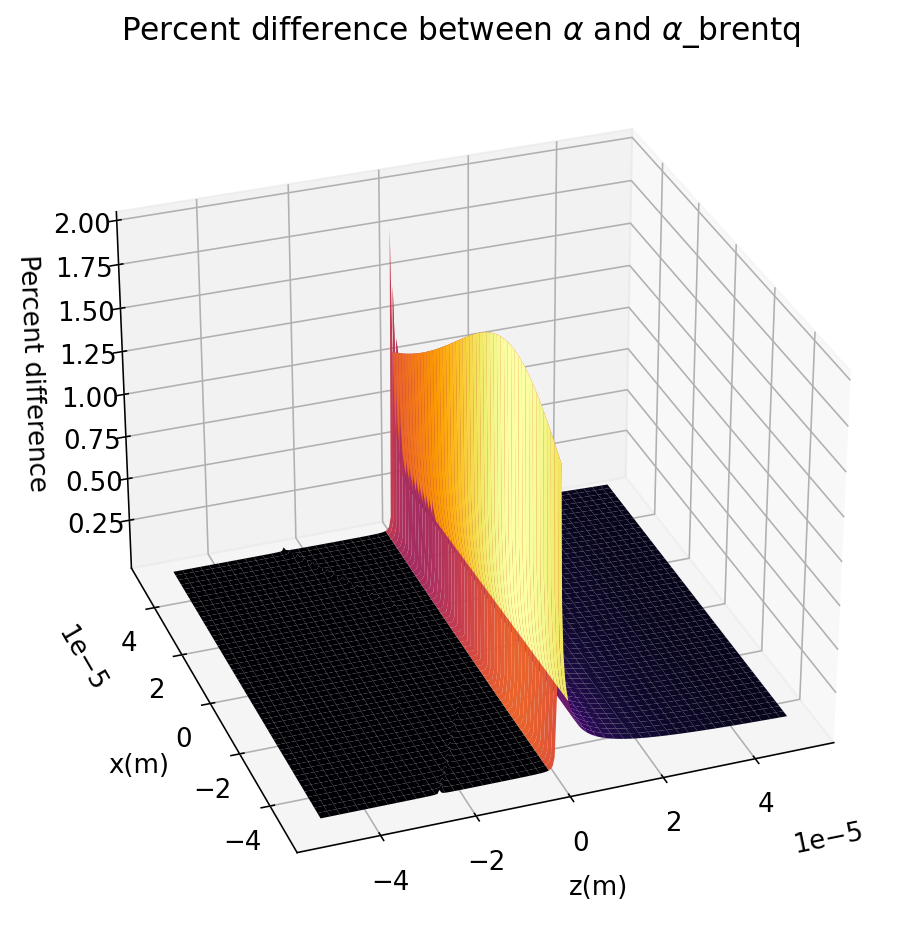

In [72]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm, xm, diff, cmap='inferno', zorder=1)


ax.set_xlabel(r'z(m)', labelpad = 10)
ax.set_ylabel(r'x(m)', labelpad = 10)
ax.set_zlabel(r'Percent difference', labelpad = 18)
ax.zaxis.labelpad = 10
ax.set_title(r'Percent difference between $\alpha$ and $\alpha$_brentq')

ax.azim = 250

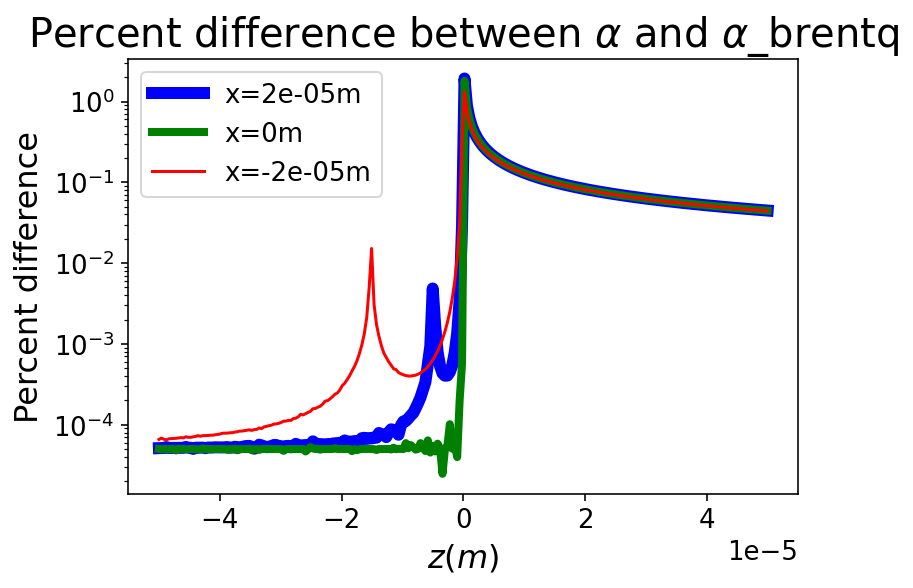

In [73]:
x_o = 2*sigma_x
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, 100], label= f'x={x_o}m', c='blue', linewidth=6)
plt.yscale('log')

x_o = 0
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, xix], label= f'x={x_o}m', c='green', linewidth=4)


x_o = -2*sigma_x
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, 200], label= f'x={x_o}m', c='red')

plt.xlabel(r'$z(m)$', fontsize=16)
plt.ylabel('Percent difference', fontsize=16)
plt.title(r'Percent difference between $\alpha$ and $\alpha$_brentq',  fontsize=20)
plt.legend()

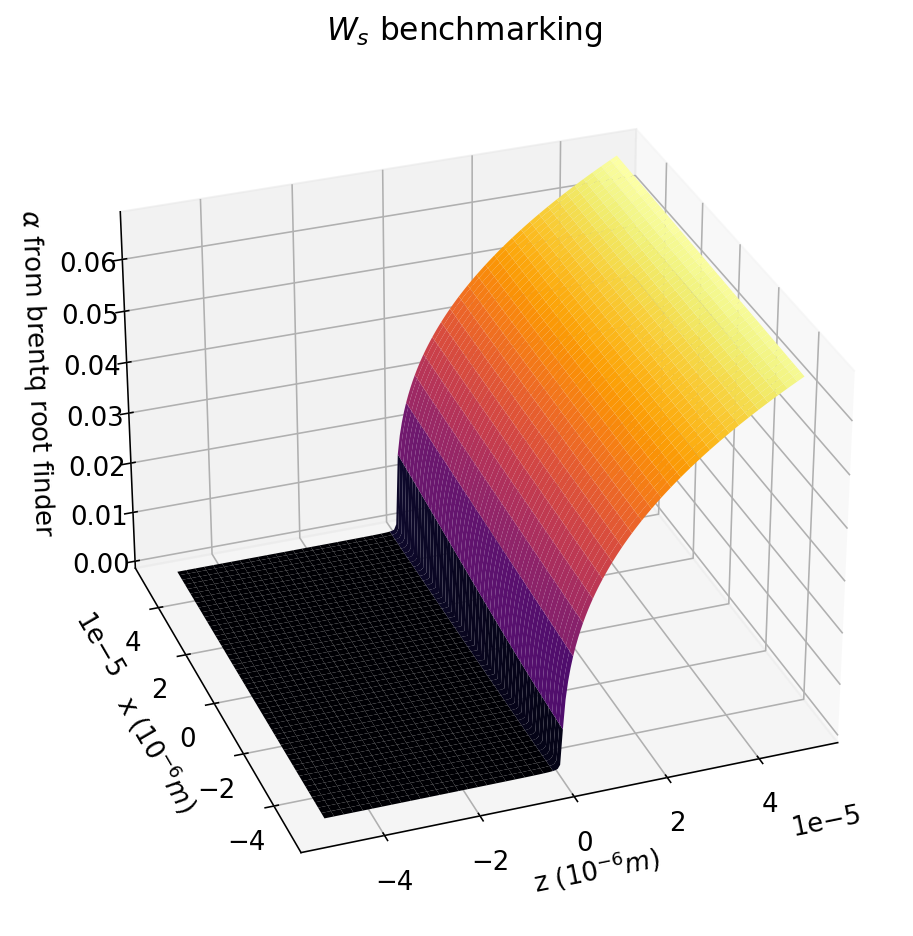

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm, xm, aa, cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-6}m)$')
ax.set_ylabel(r'x $(10^{-6}m)$')
ax.set_zlabel(r'$\alpha$ from brentq root finder ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_s$ benchmarking')

ax.azim = 250

In [ ]:
from scipy.ndimage import map_coordinates
map_coordinates(Ws_grid, np.array([zcoord, xcoord]), order=2)

In [1]:
from fast_interp import interp2d
import numpy as np

nx = 50
ny = 37
xv, xh = np.linspace(0, 1,       nx, endpoint=True,  retstep=True)
yv, yh = np.linspace(0, 2*np.pi, ny, endpoint=False, retstep=True)
x, y = np.meshgrid(xv, yv, indexing='ij')

test_function = lambda x, y: np.exp(x)*np.exp(np.sin(y))
f = test_function(x, y)
test_x = -xh/2.0
test_y = 271.43
fa = test_function(test_x, test_y)

interpolater = interp2d([0,0], [1,2*np.pi], [xh,yh], f, k=5, p=[False,True], e=[1,0])
fe = interpolater(test_x, test_y)

print('Error is: {:0.2e}'.format(np.abs(fe-fa)))

/global/homes/w/wlou1991/.conda/envs/cupy/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function '_interp2d_k5'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../GitHub/fast_interp/fast_interp/fast_interp.py", line 385:
@numba.njit(parallel=True)
def _interp2d_k5(f, xout, yout, fout, a, h, n, p, o, lb, ub):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/global/homes/w/wlou1991/.conda/envs/cupy/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'h' of function '_interp2d_k5'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprec

Error is: 4.53e-06
